# Clustering-based Customer Segmentation

 ## 1. Install Required Libraries

In [1]:
!pip install kneed openpyxl

## 2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from matplotlib.colors import ListedColormap
from kneed import KneeLocator

## 3. Load and Inspect the Data

In [ ]:
# Read the Excel file
df = pd.read_excel("~/Documents/WQD7006/gp/processed_data_final.xlsx")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_encoded,main_category,main_category_encoded,day_of_week,month,hour,day_of_year
0,2019-10-08 05:16:23,view,1004825,2053013555631883008,electronics.smartphone,bq,39.36,547394949,c3a4ded7-ae7e-9529-9453-64e8e3ef0fb6,2,electronics,7,1,10,5,281
1,2019-10-04 05:56:37,view,2501352,2053013564003714048,appliances.kitchen.oven,beko,257.38,513147415,339c68b1-7e6b-47cc-bd4f-3049c82779dc,2,appliances,2,4,10,5,277
2,2019-10-04 18:35:44,view,1003312,2053013555631883008,electronics.smartphone,apple,703.52,513815293,7196708c-3af6-45dd-a6e6-6f2d4b271505,2,electronics,7,4,10,18,277
3,2019-10-02 12:59:07,view,1005018,2053013555631883008,electronics.smartphone,huawei,95.82,512388419,297154b9-3db5-4f59-9113-acfd61d7db28,2,electronics,7,2,10,12,275
4,2019-10-13 14:32:18,view,4201166,2053013552351937024,appliances.environment.air_conditioner,tcl,295.22,512771890,2eff34cc-a57e-4a79-8cc3-c5d803f5ac8b,2,appliances,2,6,10,14,286


## 4. Create Aggregated User Features

In [4]:
user_features = df.groupby('user_id').agg(
    activity_frequency=('event_type', 'count'),
    category_count=('main_category', 'nunique'),
    event_type_count=('event_type', 'nunique'),
    unique_products=('product_id', 'nunique'),
    unique_brands=('brand', 'nunique'),
    average_spend=('price', 'mean')
).reset_index()

user_features.head()

,user_id,activity_frequency,category_count,event_type_count,unique_products,unique_brands,average_spend
0,301573329,1,1,1,1,1,420.60
1,363209635,1,1,1,1,1,39.35
2,388330497,1,1,1,1,1,189.97
3,398709573,1,1,1,1,1,529.74
4,432867328,1,1,1,1,1,33.45


## 5. Normalize and Prepare Features

In [5]:
# Extract base numeric features
base_features = ['activity_frequency', 'category_count', 'event_type_count', 'unique_products', 'unique_brands', 'average_spend']

# Identify one-hot encoded category features if available
category_cols = [col for col in user_features.columns if col.startswith('top_category_')]

# Final feature list
features = base_features + category_cols

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_features[features])

print("Base features:", base_features)
print("Category features:", category_cols)
print("Final shape:", scaled_data.shape)


Base features: ['activity_frequency', 'category_count', 'event_type_count', 'unique_products', 'unique_brands', 'average_spend']
Category features: []
Final shape: (17966, 6)


## 6. Determine Optimal K using Elbow Method

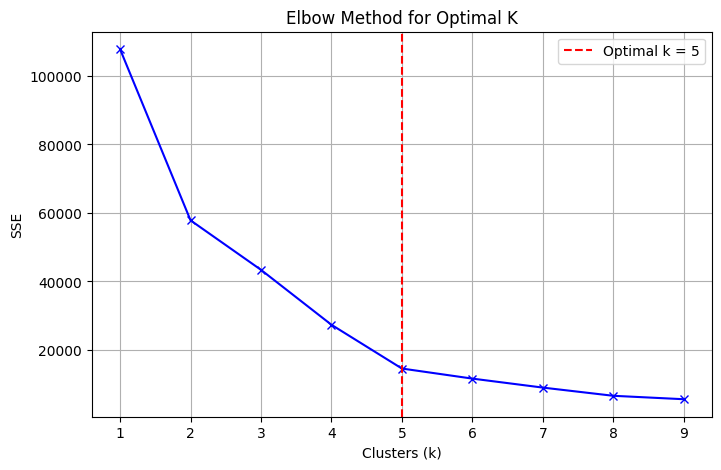

Optimal k detected: 5


In [6]:
sse = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

kneedle = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
optimal_k = kneedle.knee

plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')

if optimal_k:
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
    plt.legend()

plt.grid(True)
plt.show()
print(f"Optimal k detected: {optimal_k}")


## 7. Fit Clustering Models

In [7]:
# KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_features['cluster_kmeans'] = kmeans.fit_predict(scaled_data)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=optimal_k)
agglo_labels = agglo.fit_predict(scaled_data)


## 8. Evaluate Clustering Models

In [8]:
def evaluate_clustering(name, data, labels):
    if len(set(labels)) <= 1 or (set(labels) == {-1}):
        print(f"{name}: Not enough clusters to evaluate.")
        return
    print(f"\n--- {name} ---")
    print(f"Silhouette Score: {silhouette_score(data, labels):.3f}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score(data, labels):.3f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(data, labels):.3f}")

evaluate_clustering("KMeans", scaled_data, user_features['cluster_kmeans'])
evaluate_clustering("DBSCAN", scaled_data, dbscan_labels)
evaluate_clustering("Agglomerative", scaled_data, agglo_labels)



--- KMeans ---
Silhouette Score: 0.681
Davies-Bouldin Index: 0.464
Calinski-Harabasz Index: 28740.854

--- DBSCAN ---
Silhouette Score: 0.826
Davies-Bouldin Index: 1.107
Calinski-Harabasz Index: 5741.323

--- Agglomerative ---
Silhouette Score: 0.649
Davies-Bouldin Index: 0.577
Calinski-Harabasz Index: 24616.955


## 9. Visualize Clusters with PCA

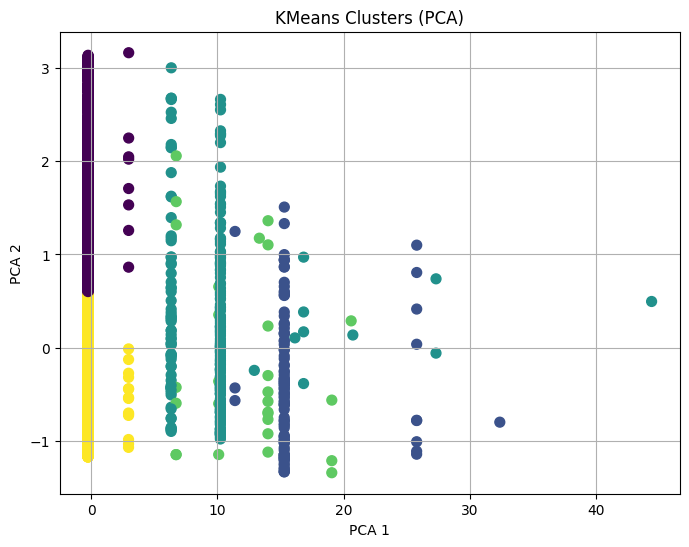

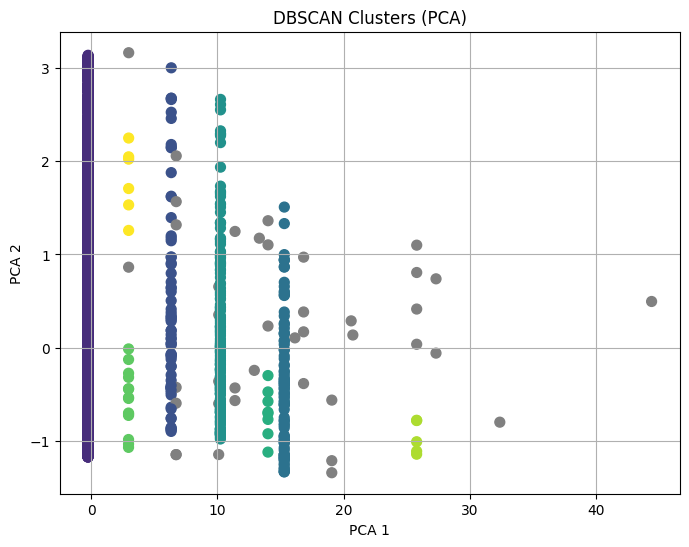

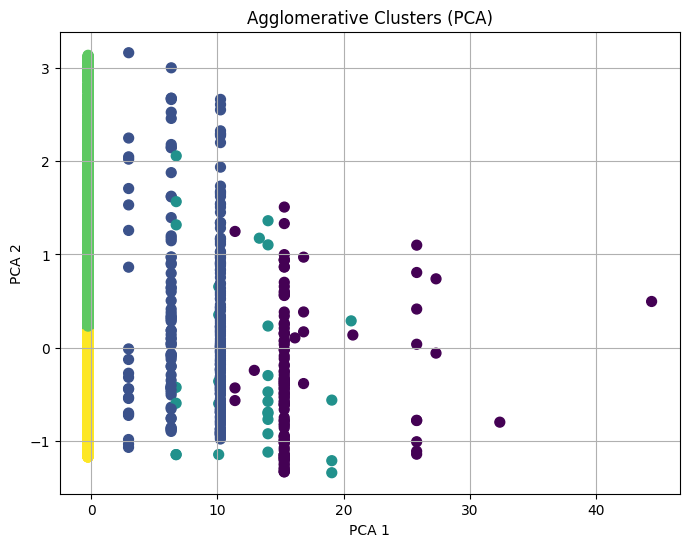

In [9]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

def plot_clusters(title, labels):
    plt.figure(figsize=(8,6))
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('viridis', len(unique_labels))
    color_list = [colors(i) for i in range(len(unique_labels))]

    if -1 in unique_labels:
        color_list[list(unique_labels).index(-1)] = (0.5, 0.5, 0.5, 1)  # grey for noise

    cmap = ListedColormap(color_list)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap=cmap, s=50)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

plot_clusters("KMeans Clusters (PCA)", user_features['cluster_kmeans'])
plot_clusters("DBSCAN Clusters (PCA)", dbscan_labels)
plot_clusters("Agglomerative Clusters (PCA)", agglo_labels)


## 10. Hyperparameter Tuning for KMeans

In [10]:
param_grid = {
    'n_clusters': [optimal_k-2, optimal_k, optimal_k+2],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300],
    'algorithm': ['lloyd', 'elkan']
}

results = []
best_score = -1

for params in ParameterGrid(param_grid):
    if params['n_clusters'] < 2:
        continue
    model = KMeans(**params, random_state=42)
    labels = model.fit_predict(scaled_data)

    try:
        sil = silhouette_score(scaled_data, labels)
        db = davies_bouldin_score(scaled_data, labels)
        ch = calinski_harabasz_score(scaled_data, labels)
        results.append({**params, 'silhouette': sil, 'db': db, 'ch': ch})
        if sil > best_score:
            best_score = sil
            best_params = params
    except:
        continue

results_df = pd.DataFrame(results).sort_values(by='silhouette', ascending=False)
results_df.head(10)


,algorithm,init,max_iter,n_clusters,n_init,silhouette,db,ch
1,lloyd,k-means++,300,3,20,0.909668,0.602795,15166.540148
13,elkan,k-means++,300,3,20,0.909668,0.602795,15166.540148
12,elkan,k-means++,300,3,10,0.908335,0.702869,13337.206887
0,lloyd,k-means++,300,3,10,0.908335,0.702869,13337.206887
14,elkan,k-means++,300,5,10,0.681515,0.463990,28740.886341
15,elkan,k-means++,300,5,20,0.681515,0.463990,28740.886341
2,lloyd,k-means++,300,5,10,0.681515,0.463990,28740.886341
3,lloyd,k-means++,300,5,20,0.681515,0.463990,28740.886341
18,elkan,random,300,3,10,0.672661,0.763965,12871.070599
19,elkan,random,300,3,20,0.672661,0.763965,12871.070599


## 11. Cluster Interpretation (Example: Agglomerative 3 Clusters)

In [11]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(user_features.drop(columns=['user_id', 'cluster_kmeans']))

agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
user_features['final_cluster'] = agg.fit_predict(features_scaled)

cluster_summary = user_features.groupby('final_cluster').mean(numeric_only=True)
print(cluster_summary)


                    user_id  activity_frequency  category_count  \
final_cluster                                                     
0              5.339329e+08            1.021130        1.005631   
1              5.123660e+08            6.000000        1.000000   
2              5.352004e+08            2.071429        1.107143   

               event_type_count  unique_products  unique_brands  \
final_cluster                                                     
0                           1.0         1.019847       1.015276   
1                           1.0         6.000000       4.000000   
2                           2.0         1.785714       1.535714   

               average_spend  cluster_kmeans  
final_cluster                                 
0                 268.692182        3.102358  
1                 260.268333        2.000000  
2                 254.423155        3.000000  


## 12. Behavioral Segmentation

In [12]:
segment_descriptions = {
    0: "Single High-Value Users - One-time buyers with high spend.",
    1: "Active Loyal Users - Frequent buyers in a single category.",
    2: "Occasional Explorers - Moderate activity across categories."
}

for i, group in user_features.groupby('final_cluster'):
    print(f"\nCluster {i}: {segment_descriptions[i]}")
    print(group.describe(include='all'))



Cluster 0: Single High-Value Users - One-time buyers with high spend.
            user_id  activity_frequency  category_count  event_type_count  \
count  1.793700e+04        17937.000000    17937.000000           17937.0   
mean   5.339329e+08            1.021130        1.005631               1.0   
std    1.862746e+07            0.153932        0.074829               0.0   
min    3.015733e+08            1.000000        1.000000               1.0   
25%    5.160390e+08            1.000000        1.000000               1.0   
50%    5.302658e+08            1.000000        1.000000               1.0   
75%    5.522714e+08            1.000000        1.000000               1.0   
max    5.662385e+08            4.000000        2.000000               1.0   

       unique_products  unique_brands  average_spend  cluster_kmeans  \
count     17937.000000   17937.000000   17937.000000    17937.000000   
mean          1.019847       1.015276     268.692182        3.102358   
std           0.149

## 13. Merge Clusters Back to Original Dataset

In [13]:
df = df.merge(user_features[['user_id', 'final_cluster']], on='user_id', how='left')
df.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_encoded,main_category,main_category_encoded,day_of_week,month,hour,day_of_year,final_cluster
0,2019-10-08 05:16:23,view,1004825,2053013555631883008,electronics.smartphone,bq,39.36,547394949,c3a4ded7-ae7e-9529-9453-64e8e3ef0fb6,2,electronics,7,1,10,5,281,0
1,2019-10-04 05:56:37,view,2501352,2053013564003714048,appliances.kitchen.oven,beko,257.38,513147415,339c68b1-7e6b-47cc-bd4f-3049c82779dc,2,appliances,2,4,10,5,277,0
2,2019-10-04 18:35:44,view,1003312,2053013555631883008,electronics.smartphone,apple,703.52,513815293,7196708c-3af6-45dd-a6e6-6f2d4b271505,2,electronics,7,4,10,18,277,0
3,2019-10-02 12:59:07,view,1005018,2053013555631883008,electronics.smartphone,huawei,95.82,512388419,297154b9-3db5-4f59-9113-acfd61d7db28,2,electronics,7,2,10,12,275,0
4,2019-10-13 14:32:18,view,4201166,2053013552351937024,appliances.environment.air_conditioner,tcl,295.22,512771890,2eff34cc-a57e-4a79-8cc3-c5d803f5ac8b,2,appliances,2,6,10,14,286,0


# Assign New User

## 14. Save the Scaler for Later Use

In [14]:
import pickle

# Save the StandardScaler used in training
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


## 15. Interactive New User Cluster Assignment Interface

In [23]:
# --- Install if needed ---
!pip install -q ipywidgets


In [24]:
# --- Imports ---
import pandas as pd
import numpy as np
import pickle
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


In [25]:
# --- Load Features and Scaler ---
features = ['activity_frequency', 'category_count', 'event_type_count',
            'unique_products', 'unique_brands', 'average_spend']

# Load saved scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load your existing user feature data (excluding user_id/cluster)
training_data = user_features[features].copy()


In [26]:
# --- Create Input Fields ---
activity_input = widgets.BoundedIntText(value=10, min=0, max=100, description='Activity Freq:')
category_input = widgets.BoundedIntText(value=5, min=0, max=20, description='Category Count:')
event_input = widgets.BoundedIntText(value=10, min=0, max=100, description='Event Types:')
product_input = widgets.BoundedIntText(value=5, min=0, max=50, description='Unique Products:')
brand_input = widgets.BoundedIntText(value=3, min=0, max=30, description='Unique Brands:')
spend_input = widgets.BoundedFloatText(value=100.0, min=0, max=1000, step=1.0, description='Avg Spend:')


In [27]:
# --- Display All Input Widgets ---
input_box = widgets.VBox([
    activity_input,
    category_input,
    event_input,
    product_input,
    brand_input,
    spend_input
])
display(input_box)


✅ New user assigned to: Cluster 0
📌 Interpretation: 💼 Cluster 0 – Occasional Explorers


In [30]:
# --- Callback: Auto-Trigger When Any Field Changes ---
def assign_cluster(change):
    # If any value is still None or empty, skip
    try:
        # Gather new input as DataFrame
        new_data = pd.DataFrame([{
            'activity_frequency': activity_input.value,
            'category_count': category_input.value,
            'event_type_count': event_input.value,
            'unique_products': product_input.value,
            'unique_brands': brand_input.value,
            'average_spend': spend_input.value
        }])

        # Combine with original data
        combined = pd.concat([training_data, new_data], ignore_index=True)

        # Scale
        scaled = scaler.transform(combined)

        # Re-cluster
        model = AgglomerativeClustering(n_clusters=3, linkage='average', metric='euclidean')
        labels = model.fit_predict(scaled)

        # Get new user's cluster
        new_cluster = labels[-1]

        # Interpret
        interpretations = {
            0: "💼 Cluster 0 – Occasional Explorers",
            1: "🛒 Cluster 1 – Frequent Shoppers",
            2: "💳 Cluster 2 – High Spenders"
        }
        interpretation = interpretations.get(new_cluster, "Unknown Cluster")

        clear_output(wait=True)
        display(input_box)
        print(f"✅ New user assigned to: Cluster {new_cluster}")
        print(f"📌 Interpretation: {interpretation}")
    except:
        pass  # Wait for all inputs to be filled

# Attach change listeners to each input field
for widget in [activity_input, category_input, event_input, product_input, brand_input, spend_input]:
    widget.observe(assign_cluster, names='value')


# user_features.csv

In [32]:
# --- Step 1: Install Required Libraries (if needed) ---
!pip install -q openpyxl

# --- Step 2: Import Libraries ---
import pandas as pd

# --- Step 3: Load Processed Data from Excel ---
df = pd.read_excel('processed_data_final.xlsx')

# --- Step 4: Group by User and Create Aggregated Features ---
user_features = df.groupby('user_id').agg(
    activity_frequency=('event_type', 'count'),
    category_count=('main_category', 'nunique'),
    event_type_count=('event_type', 'nunique'),
    unique_products=('product_id', 'nunique'),
    unique_brands=('brand', 'nunique'),
    average_spend=('price', 'mean')
).reset_index()

# --- Step 5: Drop user_id column ---
user_features = user_features.drop(columns=['user_id'])

# --- Step 6: Save to CSV ---
user_features.to_csv('user_features.csv', index=False)

# Optional: Display the result
user_features.head()


,activity_frequency,category_count,event_type_count,unique_products,unique_brands,average_spend
0,1,1,1,1,1,420.60
1,1,1,1,1,1,39.35
2,1,1,1,1,1,189.97
3,1,1,1,1,1,529.74
4,1,1,1,1,1,33.45


In [33]:
from google.colab import files
files.download('user_features.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>